In [1]:
import monai
import pandas as pd
import numpy as np
import os
import json
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import DtypeLike
from monai.data.meta_obj import get_track_meta
from monai.utils.type_conversion import convert_data_type, convert_to_tensor
from monai.transforms.transform import  MapTransform
from monai.data.meta_obj import get_track_meta
from typing import Callable, Hashable, Mapping, Sequence
from monai.config import DtypeLike, KeysCollection
import torch

from radiomics.featureextractor import RadiomicsFeatureExtractor 

exposure, has_skimage = monai.utils.optional_import("skimage.exposure")

 missing cuda symbols while dynamic loading
 cuFile initialization failed


In [2]:
def calculate_image_histogram(img: np.ndarray, mask: np.ndarray | None = None, num_bins: int = 256):
    
    hist_img = img[np.array(mask, dtype=bool)] if mask is not None else img
    if has_skimage:
        hist, bins = exposure.histogram(hist_img.flatten(), num_bins)
    else:
        hist, bins = np.histogram(hist_img.flatten(), num_bins)
        bins = (bins[:-1] + bins[1:]) / 2
    return hist, bins

In [3]:
class ComputeHistogramd(MapTransform):
    """
    Args:
        num_bins: number of the bins to use in histogram, default to `256`. for more details:
            https://numpy.org/doc/stable/reference/generated/numpy.histogram.html.
        min: the min value to normalize input image, default to `0`.
        max: the max value to normalize input image, default to `255`.
        mask: if provided, must be ndarray of bools or 0s and 1s, and same shape as `image`.
            only points at which `mask==True` are used for the equalization.
            can also provide the mask along with img at runtime.
        dtype: data type of the output, if None, same as input image. default to `float32`.

    """

    def __init__(
        self,
        keys: KeysCollection,
        num_bins: int = 256,
        min: int = 0,
        max: int = 255,
        mask: NdarrayOrTensor | None = None,
        mask_key: str | None = None,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        
        super().__init__(keys, allow_missing_keys)
        self.num_bins = num_bins
        self.min = min
        self.max = max
        self.mask = mask
        self.dtype = dtype
        self.mask_key = mask_key if mask is None else None

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            img = d[key]
            mask = d[self.mask_key] if self.mask_key is not None else None
            img = convert_to_tensor(img, track_meta=get_track_meta())
            img_np, *_ = convert_data_type(img, np.ndarray)
            mask_np: np.ndarray | None = None
            if mask is not None:
                mask_np, *_ = convert_data_type(mask, np.ndarray)

            hist,bins = calculate_image_histogram(img=img_np, mask=mask_np, num_bins=self.num_bins)
            d[f'{key}_hist'] = hist
            d[f'{key}_bins'] = bins
        

        return d

In [4]:
path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021"
derivatives_path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021/derivatives/creating_adc"
t2_list = []
adc_list = []
dwi_list = []

# Creating a list of all the files in the directory starting with sub-*
subjects = [f for f in os.listdir(path) if f.startswith("sub-")]
derivatives_subs = [f for f in os.listdir(derivatives_path) if f.startswith("sub-")]

for sub in subjects:
    derivative_sessions=None
    if sub in derivatives_subs:
        derivative_sessions = [f for f in os.listdir(os.path.join(derivatives_path, sub)) if f.startswith("ses-")]
    sessions = [f for f in os.listdir(os.path.join(path, sub)) if f.startswith("ses-")]
    for ses in sessions:
        # Check if the anat and dwi paths exist
        anat_path = os.path.join(path, sub, ses,'mim-mr','anat')
        dwi_path = os.path.join(path, sub, ses,'mim-mr','dwi')

        if os.path.exists(anat_path):
            images_anat = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz")]
            for img in images_anat:
                if 'T2w' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','anat', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'T2w'}
                    img_dict.update(data)
                    t2_list.append(img_dict)
        if os.path.exists(dwi_path):
            images_dwi = [f for f in os.listdir(dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                if 'bvalue' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'dwi'}
                    img_dict.update(data)
                    dwi_list.append(img_dict)
                elif 'adc' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                    img_dict.update(data)
                    adc_list.append(img_dict)
    if derivative_sessions:
        for ses in derivative_sessions:
            der_dwi_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi')
            images_dwi = [f for f in os.listdir(der_dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                json_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                with open(json_path) as f:
                    data = json.load(f)
                #Add json data to the dict image
                img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'derivatives-adc'}
                img_dict.update(data)
                adc_list.append(img_dict)


t2w_df = pd.DataFrame(t2_list)
dwi_df = pd.DataFrame(dwi_list)
adc_df = pd.DataFrame(adc_list)


In [5]:
t2w_df

,subject,session,image,modality,AccessionNumber,AcquisitionDate,AcquisitionMatrix,AcquisitionNumber,AcquisitionTime,AngioFlag,...,BurnedInAnnotation,LossyImageCompression,NumberOfStudyRelatedInstances,PatientIdentityRemoved,SequenceName,TransmitCoilName,TemporalResolution,PixelPaddingValue,ContentQualification,ContrastBolusRoute
0,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-3_bp-prostat...,T2w,000063,20160707,"[0, 320, 256, 0]",1,145247,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-8_bp-prostat...,T2w,000063,20160707,"[320, 0, 0, 224]",1,151334,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-6_bp-prostat...,T2w,000063,20160707,"[320, 0, 0, 224]",1,150232,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-3_bp-prostat...,T2w,000066,20170127,"[0, 320, 224, 0]",1,152652,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-5_bp-prostat...,T2w,000066,20170127,"[0, 320, 256, 0]",1,153336,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,sub-000003,ses-000003,sub-000003_ses-000003_acq-fse_run-8_bp-arm_vp-...,T2w,000003,20140307,"[0, 320, 256, 0]",1,082739,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-5_bp-abdomen...,T2w,000111,20150624,"[0, 320, 256, 0]",1,194350,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-8_bp-abdomen...,T2w,000111,20150624,"[320, 0, 0, 224]",1,195541,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,sub-000120,ses-000120,sub-000120_ses-000120_acq-fse_run-8_bp-abdomen...,T2w,000120,20140924,"[320, 0, 0, 224]",1,081911,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
images_paths = t2w_df.copy().apply(lambda x: os.path.join(path, x['subject'], x['session'],'mim-mr','anat', x['image']), axis=1)

In [7]:

# Divide into axial, coronal and sagital images
data_list = []
for path in images_paths.values:
    files = {}
    image_name = path.split('/')[-1]
    files['image'] = path        
    data_list.append(files)

transforms = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"],allow_missing_keys=True,image_only=False),
                #monai.transforms.ScaleIntensityd(keys=["image"]),
                ComputeHistogramd(keys=["image"], mask_key=None, num_bins=50, min=0, max=255, dtype=np.float32, allow_missing_keys=True)
                ]
)

train_ds = monai.data.Dataset(
    data=data_list,
    transform=transforms,
)

In [45]:
train_ds[0]

{'image': metatensor([[[ 0.,  0.,  0.,  ...,  2.,  2.,  2.],
          [ 3.,  5.,  8.,  ...,  6.,  8., 12.],
          [12., 12., 13.,  ...,  6., 10., 12.],
          ...,
          [ 0.,  0.,  0.,  ...,  3.,  3.,  1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  3.,  4.,  2.],
          [ 3.,  4., 10.,  ...,  6., 11., 11.],
          [11.,  9., 15.,  ...,  8., 13., 11.],
          ...,
          [ 0.,  0.,  0.,  ...,  3.,  3.,  2.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  3.,  4.,  2.],
          [ 3.,  5.,  9.,  ...,  7., 11., 10.],
          [11., 14., 16.,  ..., 14., 16., 14.],
          ...,
          [ 0.,  0.,  1.,  ...,  6.,  8.,  5.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         ...,
 
         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
     

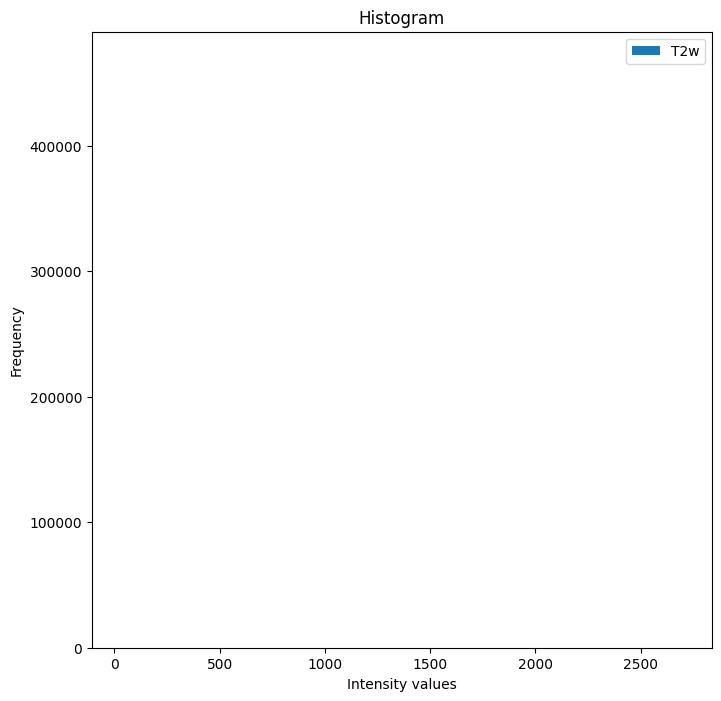

In [46]:
#plotting the histogram
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.bar(train_ds[0]['image_bins'], train_ds[0]['image_hist'], label='T2w')
ax.set_title('Histogram')
ax.set_xlabel('Intensity values')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


## Get Radiomic Features

In [7]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from numpy import std,mean

In [8]:
data_list = []
for path in images_paths.values:
    files = {}
    image_name = path.split('/')[-1]
    files['image'] = path        
    data_list.append(files)


In [14]:
def delete_black_slices(image: sitk.Image, threshold: float = 0.5):
    #image = sitk.ReadImage(image_path)
    
    data = sitk.GetArrayFromImage(image)
    img_std = std(data, keepdims=False)
    std_per_slice_axis1 = std(data, axis=(1, 2), keepdims=False)
    std_per_slice_axis2 = std(data, axis=(0, 2), keepdims=False)
    std_per_slice_axis3 = std(data, axis=(0, 1), keepdims=False)

    img_mean = mean(data, keepdims=False)
    mean_per_slice_axis1 = mean(data, axis=(1, 2), keepdims=False)
    mean_per_slice_axis2 = mean(data, axis=(0, 2), keepdims=False)
    mean_per_slice_axis3 = mean(data, axis=(0, 1), keepdims=False)

    mask_axis1 = (std_per_slice_axis1 > threshold * img_std) & (mean_per_slice_axis1 > threshold * img_mean)
    mask_axis2 = (std_per_slice_axis2 > threshold * img_std) & (mean_per_slice_axis2 > threshold * img_mean)
    mask_axis3 = (std_per_slice_axis3 > threshold * img_std) & (mean_per_slice_axis3 > threshold * img_mean)

    mask = np.full(data.shape, False)

    mask[np.ix_(mask_axis1, mask_axis2, mask_axis3)] = True
    # mask[mask_axis1, mask, :] = True
    # mask[:,mask_axis2,:] = True
    # mask[:,:,mask_axis3] = True
    masked_image = data[mask_axis1, :, :]
    masked_image = data[:, mask_axis2, :]
    masked_image = data[:, :, mask_axis3]
    
    
    #convert mask to simpleitk image
    mask = sitk.GetImageFromArray(mask.astype(np.uint8))
    mask.CopyInformation(image)

    #sitk.WriteImage(mask, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz")
    return mask, masked_image


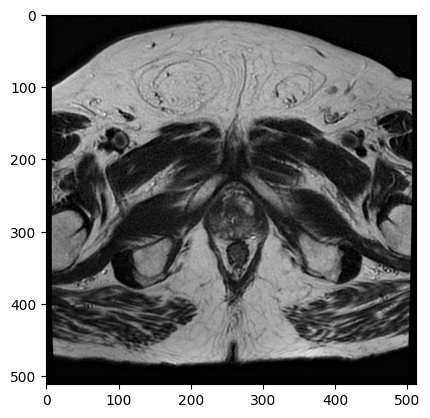

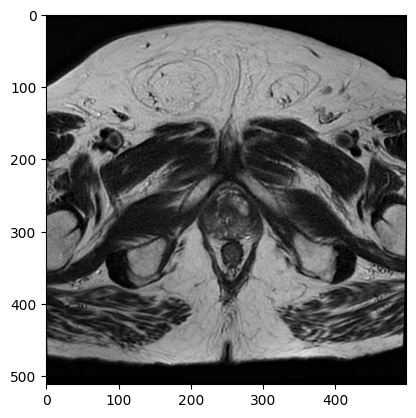

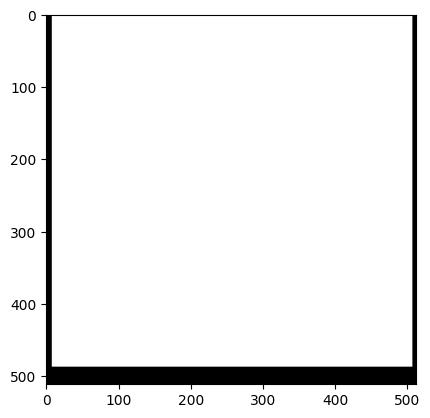

In [11]:
# Read Image using SimpleITK


image = sitk.ReadImage(images_paths[107])

#plot the image
plt.imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
plt.show()

#Apply tresholding to delete black zones with SimpleITK filters
mask, filtered_image = delete_black_slices(image, threshold=0.2)

plt.imshow(filtered_image[5,:,:], cmap='gray')
plt.show()

#plot the mask
plt.imshow(sitk.GetArrayFromImage(mask)[5,:,:], cmap='gray')
plt.show()

#save mask as temporal file
#sitk.WriteImage(mask, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz")

#save image as temporal file
#sitk.WriteImage(image, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_image.nii.gz")



In [12]:
#Extracting radiomics features
extractor = RadiomicsFeatureExtractor()

features = extractor.execute(image, mask)
features

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.3'),
             ('diagnostics_Versions_SimpleITK', '2.3.1'),
             ('diagnostics_Versions_PyWavelet', '1.6.0'),
             ('diagnostics_Versions_Python', '3.10.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diag

In [48]:
import logging  # to track running
import os  # help us load files and deal with paths
from multiprocessing import cpu_count, Pool
import threading
import pandas as pd  # for reading and writing tables
import SimpleITK as sitk
import radiomics  # radiomics package
from radiomics import featureextractor
import numpy as np
import pandas as pd


from pathlib import Path

In [49]:
def calculate_radiomics(case): 
    settings = {}
    settings["binWidth"] = 25
    settings["resampledPixelSpacing"] = None
    settings["interpolator"] = sitk.sitkBSpline
    settings["enableCExtensions"] = True
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

    print(
        f"Processing Patient {case['ID']} (Image: {case['Image']}, Mask: {case['Mask']})"
    )

    image_path = case["Image"]
    image = sitk.ReadImage(image_path)

    mask,masked_image = delete_black_slices(image, threshold=0.2)

    values = np.unique(sitk.GetArrayFromImage(mask))
    # Uncomment if you want to check the number and values of all labels in the mask
    # print(values)
    values = np.array([1])  # Specify the values of labels of interest
    # Uncomment if you want to analyse all labels of mask
    # values = np.delete(values, 0)
    patient = pd.Series()
    patient.name = case["ID"]
    for label in values:
        label = int(label)
        print(
            f"Processing Patient {case['ID']} (Image: {case['Image']}, Mask: {mask}, Label: {label})"
        )
        if (image is not None) and (mask is not None):
            try:
                result = pd.Series(extractor.execute(image, mask, label))
            except Exception as e:
                print("FEATURE EXTRACTION FAILED:", str(e))
                result = pd.Series()
        else:
            print("FEATURE EXTRACTION FAILED: Missing Image and/or Mask")
            result = pd.Series()

        result.name = case["ID"]
        result = result.add_prefix(f"label{label}_")
        patient = patient.append(result)

    return patient

In [50]:
data = pd.DataFrame(columns=["ID", "Image"])
data["ID"] = t2w_df["subject"] + "_" + t2w_df["session"] + "_" + t2w_df["image"]
data["Image"] = images_paths.values

In [51]:
data

,ID,Image
0,sub-000063_ses-000063_sub-000063_ses-000063_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
1,sub-000063_ses-000063_sub-000063_ses-000063_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
2,sub-000063_ses-000063_sub-000063_ses-000063_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
3,sub-000066_ses-000066_sub-000066_ses-000066_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
4,sub-000066_ses-000066_sub-000066_ses-000066_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
...,...,...
543,sub-000003_ses-000003_sub-000003_ses-000003_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
544,sub-000111_ses-000111_sub-000111_ses-000111_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
545,sub-000111_ses-000111_sub-000111_ses-000111_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
546,sub-000120_ses-000120_sub-000120_ses-000120_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...


In [52]:
outPath = "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/"
## Rename following files with the selected masks
outputFilepath = os.path.join(outPath, "Picai_val_radiomics_features_t2w.csv")
outputSummary = os.path.join(outPath, "Picai_val_radiomics_summary_t2w.csv")
progress_filename = os.path.join(outPath, "Picai_val_radiomics_log_t2w.txt")
params = os.path.join(outPath, "Params.yaml")

In [54]:
# Assuming 'radiomics' and 'rLogger' are already imported and configured elsewhere in your code.
print("pyradiomics version:", radiomics.__version__)
print("Loading CSV")

try:
    # Use pandas to read and transpose ('.T') the input data
    # The transposition is needed so that each column represents one test case
    # This is easier for iteration over the input cases.
    flists = data.T
except Exception as e:
    print("CSV READ FAILED:", str(e))
print("Loading Done")
print("Patients:", len(flists.columns))

col_list = []
for col in flists:
    col_list.append(flists[col])

pool = Pool(processes=(cpu_count() - 1))
l_results = pool.map(calculate_radiomics, col_list)
pool.close()
pool.join()
# Merge results in one df
results = pd.DataFrame()
for result in l_results:
    results = results.join(result, how="outer")
# General info and features in two files
# Creating an only-features CSV makes R loading easier
results = results.T
info = results.filter(regex="general", axis=1).columns
print(info)
summary = results[info]
results = results.drop(info, axis=1)

print("Extraction complete, writing CSVs")

results.to_csv(outputFilepath, na_rep="NaN")
print("Features CSV writing complete")
summary.to_csv(outputSummary, na_rep="NaN")
print("Summary CSV writing complete")

pyradiomics version: v3.0.1
Loading CSV
Loading Done
Patients: 548


TypeError: 'module' object is not callable

In [24]:
# Print the number of features extracted
print(f"Number of features extracted: {len(features)}")

Number of features extracted: 129


In [25]:
features

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.3'),
             ('diagnostics_Versions_SimpleITK', '2.3.1'),
             ('diagnostics_Versions_PyWavelet', '1.6.0'),
             ('diagnostics_Versions_Python', '3.10.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diag

## Setting up Table 

In [24]:
import pandas as pd
import numpy as np
import os
import json

In [25]:
#read Table with the features
features = pd.read_csv("Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_results_T2w_train.csv")


In [26]:
#Save in a variabble numeric features
numeric_features = features.copy().select_dtypes(include=[np.number])
#Keep only the features which name contains 'original'
#numeric_features = numeric_features[numeric_features.columns[pd.Series(numeric_features.columns).str.contains('original')]]
# Add to numeric features the Unaamed column
numeric_features['instance'] = features['Unnamed: 0']

# delete 'label_1_' from feature names
numeric_features.columns = numeric_features.columns.str.replace('label1_', '') 





In [27]:
numeric_features

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,instance
0,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,16821000.0,1.0,...,0.143118,5.828096,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06,sub-003950_ses-006079_sub-003950_ses-006079_ac...
1,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,24750000.0,1.0,...,0.091964,6.677913,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07,sub-003950_ses-006079_sub-003950_ses-006079_ac...
2,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,2806020.0,1.0,...,0.299920,4.197181,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06,sub-003950_ses-006328_sub-003950_ses-006328_ac...
3,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,2968896.0,1.0,...,0.270635,4.455283,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06,sub-003950_ses-006328_sub-003950_ses-006328_ac...
4,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,2938068.0,1.0,...,0.278429,4.351684,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06,sub-003950_ses-006328_sub-003950_ses-006328_ac...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,684.946071,0.0,1794.0,5100320.0,1.0,0.000166,-2.810188,4.000715,3725568.0,1.0,...,0.283088,4.656605,0.000592,3.334281e+09,119691.003373,4.577597e-06,0.117274,0.027122,4.573868e-06,sub-007635_ses-008424_sub-007635_ses-008424_ac...
4604,684.500005,0.0,1796.0,5140800.0,1.0,0.000180,-2.799380,4.007330,3763488.0,1.0,...,0.336530,4.257844,0.000864,2.283062e+09,126069.905364,4.470376e-06,0.118876,0.027769,4.465527e-06,sub-007635_ses-008424_sub-007635_ses-008424_ac...
4605,787.201513,0.0,1963.0,10912000.0,1.0,0.030076,-2.389987,2.903385,19270810.0,1.0,...,0.233753,4.876241,0.000270,3.349159e+10,489222.401355,1.371389e-06,0.075678,0.018415,1.371298e-06,sub-007635_ses-008424_sub-007635_ses-008424_ac...
4606,691.180708,0.0,2122.0,6486688.0,1.0,0.013163,-2.295225,3.884694,6365094.0,1.0,...,0.248321,4.828019,0.000407,7.986059e+09,210066.090279,3.105136e-06,0.101192,0.024513,3.103421e-06,sub-007635_ses-008424_sub-007635_ses-008424_ac...


In [ ]:
path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021"
derivatives_path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021/derivatives/creating_adc"
t2_list = []
adc_list = []
dwi_list = []

# Creating a list of all the files in the directory starting with sub-*
subjects = [f for f in os.listdir(path) if f.startswith("sub-")]
derivatives_subs = [f for f in os.listdir(derivatives_path) if f.startswith("sub-")]


for sub in subjects:
    derivative_sessions=None
    if sub in derivatives_subs:
        derivative_sessions = [f for f in os.listdir(os.path.join(derivatives_path, sub)) if f.startswith("ses-")]
    sessions = [f for f in os.listdir(os.path.join(path, sub)) if f.startswith("ses-")]
    for ses in sessions:
        # Check if the anat and dwi paths exist
        anat_path = os.path.join(path, sub, ses,'mim-mr','anat')
        dwi_path = os.path.join(path, sub, ses,'mim-mr','dwi')

        if os.path.exists(anat_path):
            images_anat = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz")]
            for img in images_anat:
                if 'T2w' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','anat', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'T2w'}
                    img_dict.update(data)
                    t2_list.append(img_dict)
        if os.path.exists(dwi_path):
            images_dwi = [f for f in os.listdir(dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                if 'bvalue' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'dwi'}
                    img_dict.update(data)
                    dwi_list.append(img_dict)
                elif 'adc' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                    img_dict.update(data)
                    adc_list.append(img_dict)
    if derivative_sessions:
        for ses in derivative_sessions:
            der_dwi_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi')
            images_dwi = [f for f in os.listdir(der_dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                json_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                with open(json_path) as f:
                    data = json.load(f)
                #Add json data to the dict image
                img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'derivatives-adc'}
                img_dict.update(data)
                adc_list.append(img_dict)


t2w_df = pd.DataFrame(t2_list)
dwi_df = pd.DataFrame(dwi_list)
adc_df = pd.DataFrame(adc_list)

In [28]:
t2w_df = pd.read_csv("/home/jaalzate/Prostate_Cancer_TFM/Data_Analysis/Tables/Train_t2w_df.csv")

In [29]:
t2w_df

,subject,session,image,modality,AccessionNumber,AcquisitionDate,AcquisitionDuration,AcquisitionMatrix,AcquisitionNumber,AcquisitionTime,...,PixelAspectRatio,AcquisitionDateTime,BurnedInAnnotation,PatientIdentityRemoved,PixelPaddingValue,ContentQualification,ContrastBolusVolume,WindowCenterWidthExplanation,TimeOfLastCalibration,PlanarConfiguration
0,sub-003629,ses-003863,sub-003629_ses-003863_acq-fse_run-801_bp-prost...,T2w,3863,20190429.0,167.241257,"[0, 240, 176, 0]",8.0,110304.120000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-003629,ses-003863,sub-003629_ses-003863_acq-fse_run-601_bp-prost...,T2w,3863,20190429.0,156.429977,"[0, 240, 181, 0]",6.0,105601.790000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-003629,ses-003863,sub-003629_ses-003863_acq-fse_run-301_bp-prost...,T2w,3863,20190429.0,276.815826,"[256, 0, 0, 190]",3.0,104739.430000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-003629,ses-003863,sub-003629_ses-003863_acq-fse_run-501_bp-prost...,T2w,3863,20190429.0,125.143990,"[0, 224, 165, 0]",5.0,105347.510000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-005730,ses-006206,sub-005730_ses-006206_acq-propeller_run-7_bp-p...,T2w,6206,20160129.0,NaN,"[0, 288, 288, 0]",1.0,134830.999486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32109,sub-003671,ses-006159,sub-003671_ses-006159_acq-fse_run-7_bp-prostat...,T2w,6159,20131202.0,NaN,"[0, 332, 272, 0]",1.0,84240.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32110,sub-003671,ses-006159,sub-003671_ses-006159_acq-fse_run-6_bp-prostat...,T2w,6159,20131202.0,NaN,"[0, 332, 288, 0]",1.0,83539.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32111,sub-003671,ses-006159,sub-003671_ses-006159_acq-fse_run-4_bp-prostat...,T2w,6159,20131202.0,NaN,"[0, 352, 272, 0]",1.0,82427.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32112,sub-003671,ses-006159,sub-003671_ses-006159_acq-fse_run-5_bp-prostat...,T2w,6159,20131202.0,NaN,"[300, 0, 0, 256]",1.0,82911.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
numeric_features["instance"][0]

'sub-003950_ses-006079_sub-003950_ses-006079_acq-fse_run-4_bp-prostate_vp-ax_T2w.nii.gz'

In [35]:
t2w_df['subject']+"_"+t2w_df['session']+"_"+t2w_df['image']

0        sub-003629_ses-003863_sub-003629_ses-003863_ac...
1        sub-003629_ses-003863_sub-003629_ses-003863_ac...
2        sub-003629_ses-003863_sub-003629_ses-003863_ac...
3        sub-003629_ses-003863_sub-003629_ses-003863_ac...
4        sub-005730_ses-006206_sub-005730_ses-006206_ac...
                               ...                        
32109    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32110    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32111    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32112    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32113    sub-003671_ses-004794_sub-003671_ses-004794_ac...
Length: 32114, dtype: object

In [39]:
# Add date to numeric features based on t2w_df
numeric_features['date'] = t2w_df['AcquisitionDate'][t2w_df['subject']+"_"+t2w_df['session']+"_"+t2w_df['image'] == numeric_features['instance']].values

# Put instance at the beginning
cols = list(numeric_features.columns)
cols = [cols[-2], cols[-1]] + cols[:-2]
numeric_features = numeric_features[cols]

#Drop nan 
numeric_features = numeric_features.dropna()



ValueError: Can only compare identically-labeled Series objects

In [40]:
# Create a key in both dataframes for merging
t2w_df['key'] = t2w_df['subject'] + "_" + t2w_df['session'] + "_" + t2w_df['image']
numeric_features['key'] = numeric_features['instance']

# Merge the dataframes on the key, keeping all rows from numeric_features and only matching rows from t2w_df
numeric_features = numeric_features.merge(t2w_df[['key', 'AcquisitionDate']], on='key', how='left')

# Rename the 'AcquisitionDate' column to 'date'
numeric_features.rename(columns={'AcquisitionDate': 'date'}, inplace=True)

# Drop the 'key' column as it's no longer needed
numeric_features.drop(columns='key', inplace=True)

# Put 'instance' and 'date' at the beginning
cols = list(numeric_features.columns)
cols.remove('instance')
cols.remove('date')
cols = ['instance', 'date'] + cols
numeric_features = numeric_features[cols]

# Drop rows with any missing values
numeric_features = numeric_features.dropna()

In [41]:
numeric_features

,instance,date,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,sub-003950_ses-006079_sub-003950_ses-006079_ac...,20140628.0,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,...,0.226963,0.143118,5.828096,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06
1,sub-003950_ses-006079_sub-003950_ses-006079_ac...,20140628.0,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,...,0.209526,0.091964,6.677913,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07
2,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,...,1.090974,0.299920,4.197181,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06
3,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,...,1.017545,0.270635,4.455283,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06
4,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,...,1.011896,0.278429,4.351684,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,sub-007635_ses-008424_sub-007635_ses-008424_ac...,20170628.0,684.946071,0.0,1794.0,5100320.0,1.0,0.000166,-2.810188,4.000715,...,0.752677,0.283088,4.656605,0.000592,3.334281e+09,119691.003373,4.577597e-06,0.117274,0.027122,4.573868e-06
4604,sub-007635_ses-008424_sub-007635_ses-008424_ac...,20170628.0,684.500005,0.0,1796.0,5140800.0,1.0,0.000180,-2.799380,4.007330,...,0.645716,0.336530,4.257844,0.000864,2.283062e+09,126069.905364,4.470376e-06,0.118876,0.027769,4.465527e-06
4605,sub-007635_ses-008424_sub-007635_ses-008424_ac...,20170628.0,787.201513,0.0,1963.0,10912000.0,1.0,0.030076,-2.389987,2.903385,...,0.698338,0.233753,4.876241,0.000270,3.349159e+10,489222.401355,1.371389e-06,0.075678,0.018415,1.371298e-06
4606,sub-007635_ses-008424_sub-007635_ses-008424_ac...,20170628.0,691.180708,0.0,2122.0,6486688.0,1.0,0.013163,-2.295225,3.884694,...,0.625317,0.248321,4.828019,0.000407,7.986059e+09,210066.090279,3.105136e-06,0.101192,0.024513,3.103421e-06


In [ ]:
file_path = "Tartaglia/Prostate_Tartaglia/New_Dataset/Validation_Dataset/variablesPT4_deps_ready_finalC_20240213.tsv"
# Read the TSV file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter="\t", dtype=str)

#Set label column
#numeric_features['label'] = df['label']

In [42]:
#Format date as %Y-%m-%d
numeric_features['date'] = pd.to_datetime(numeric_features['date'], format='%Y%m%d')
numeric_features

,instance,date,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,sub-003950_ses-006079_sub-003950_ses-006079_ac...,2014-06-28,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,...,0.226963,0.143118,5.828096,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06
1,sub-003950_ses-006079_sub-003950_ses-006079_ac...,2014-06-28,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,...,0.209526,0.091964,6.677913,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07
2,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,...,1.090974,0.299920,4.197181,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06
3,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,...,1.017545,0.270635,4.455283,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06
4,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,...,1.011896,0.278429,4.351684,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,sub-007635_ses-008424_sub-007635_ses-008424_ac...,2017-06-28,684.946071,0.0,1794.0,5100320.0,1.0,0.000166,-2.810188,4.000715,...,0.752677,0.283088,4.656605,0.000592,3.334281e+09,119691.003373,4.577597e-06,0.117274,0.027122,4.573868e-06
4604,sub-007635_ses-008424_sub-007635_ses-008424_ac...,2017-06-28,684.500005,0.0,1796.0,5140800.0,1.0,0.000180,-2.799380,4.007330,...,0.645716,0.336530,4.257844,0.000864,2.283062e+09,126069.905364,4.470376e-06,0.118876,0.027769,4.465527e-06
4605,sub-007635_ses-008424_sub-007635_ses-008424_ac...,2017-06-28,787.201513,0.0,1963.0,10912000.0,1.0,0.030076,-2.389987,2.903385,...,0.698338,0.233753,4.876241,0.000270,3.349159e+10,489222.401355,1.371389e-06,0.075678,0.018415,1.371298e-06
4606,sub-007635_ses-008424_sub-007635_ses-008424_ac...,2017-06-28,691.180708,0.0,2122.0,6486688.0,1.0,0.013163,-2.295225,3.884694,...,0.625317,0.248321,4.828019,0.000407,7.986059e+09,210066.090279,3.105136e-06,0.101192,0.024513,3.103421e-06


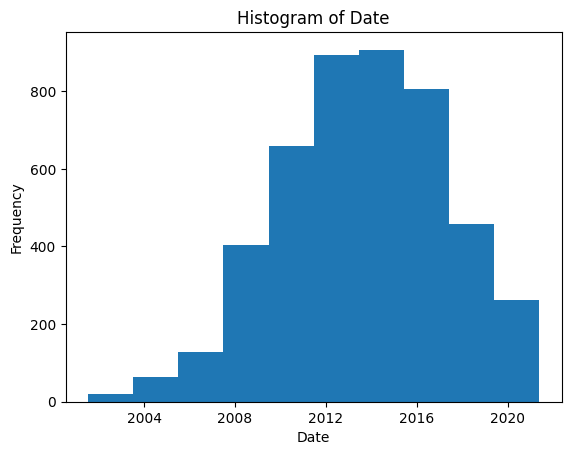

In [45]:
import matplotlib.pyplot as plt

# Assuming the dataframe is named 'df'
plt.hist(numeric_features['date'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Date')
plt.show()


In [46]:
#save the numeric features in a csv file
numeric_features.to_csv("Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/numeric_features_t2w_train.csv", index=False)